In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import json
import torch

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Setup

In [2]:
exp_name = "200904_mnist"
use_eval_runs = False
exp_type = "mnist"

In [3]:
train_files = f"../results/{exp_name}/*/config.json"
eval_files = f"../results/{exp_name}/*/eval/*/config.json"

In [4]:
if use_eval_runs:
    files = eval_files
else:
    files = train_files

In [5]:
if exp_type == "mnist":
    calibration_data = "rotated_mnist"
    ood_data = "fashion_mnist"
elif exp_type == "cifar10":
    calibration_data = "cifar10c"
    ood_data = "svhn"
else:
    raise ValueError(f"Unknown experiment type {exp_type}")

In [6]:
monolithic_priors = ["gaussian", "laplace", "student-t", "cauchy"]
hierarchical_priors = ["gaussian_gamma", "laplace_gamma", "student-t_gamma", "horseshoe", "mixture"]

In [7]:
def plot_grid(runs, y, yerr=None, ylabel="performance", ylim=None, x="weight_prior"):
    scales = sorted(runs.weight_scale.unique())
    temps = sorted(runs.temperature.unique())
    fig, axes = plt.subplots(len(scales), len(temps), sharex=True, sharey=True, figsize=(10,10))

    for scale, axs in zip(scales, axes):
        for temp, ax in zip(temps, axs):
            df = runs.sort_values([x, "weight_scale"]).query(f"weight_scale == {scale} & temperature == {temp}")
            df.plot(x=x, y=y, yerr=yerr, kind="bar", legend=False, ax=ax)
            ax.set_title(f"scale={scale} and T={temp}")
            ax.set_ylabel(ylabel)
            if ylim is not None:
                ax.set_ylim(ylim)

    fig.tight_layout()
    return fig

## Load results

In [8]:
runs = []
for config_file in glob(files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    runs.append(run_data)
runs_all = pd.concat(runs, axis=1).T

In [9]:
runs_all["error_mean"] = 1. - runs_all["acc_mean"]

In [10]:
runs_all.head()

,batch_size,batchnorm,bias_loc,bias_prior,bias_prior_params,bias_scale,burnin,cycles,data,device,...,weight_prior_params,weight_scale,width,acc_mean,acc_std,acc_stderr,lp_mean,lp_std,lp_stderr,error_mean
0,64,True,0,gaussian,{},1,10,20,mnist,try_cuda,...,{},0.7,100,0.972466,0.00130378,0.000130378,-0.0757862,0.3253,0.00325299,0.027534
1,64,True,0,gaussian,{},1,10,20,mnist,try_cuda,...,{},1.41,100,0.359991,0.258085,0.0258085,-1.5064,0.421688,0.00421688,0.640009
2,64,True,0,gaussian,{},1,10,20,mnist,try_cuda,...,{},1.41,100,0.232711,0.221504,0.0221504,-1.85712,0.230871,0.00230871,0.767289
3,64,True,0,gaussian,{},1,10,20,mnist,try_cuda,...,{},1.41,100,0.157126,0.18771,0.018771,-1.94701,0.0731617,0.000731617,0.842874
4,64,True,0,gaussian,{},1,10,20,mnist,try_cuda,...,{},1.41,100,0.1135,1.11582e-16,1.11582e-17,-2.30102,0.0536103,0.000536103,0.8865


## Evaluate predictive performance

In [11]:
if use_eval_runs:
    runs_selected = runs_all.query("eval_data != eval_data")  # basically checks for None
else:
    runs_selected = runs_all

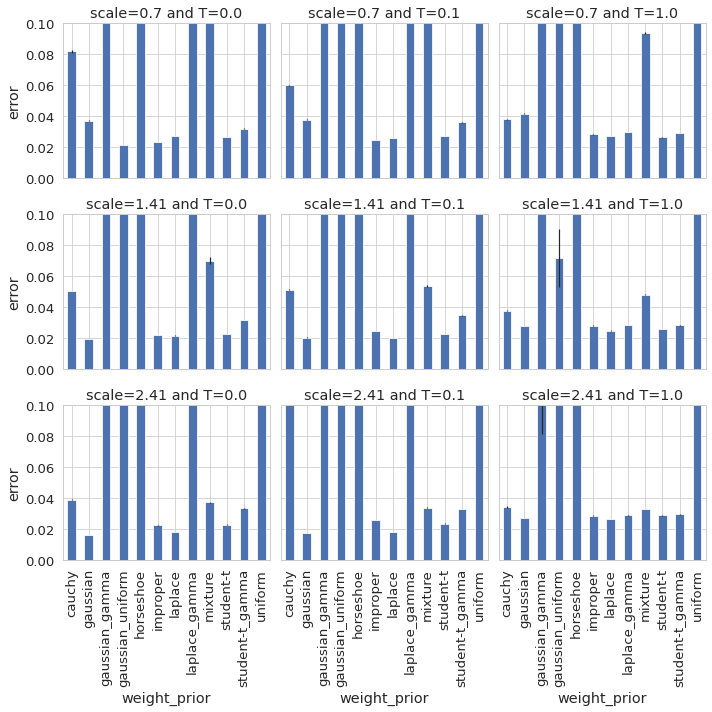

In [12]:
fig = plot_grid(runs_selected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [13]:
fig.savefig(f"../figures/{exp_name}_acc.pdf")

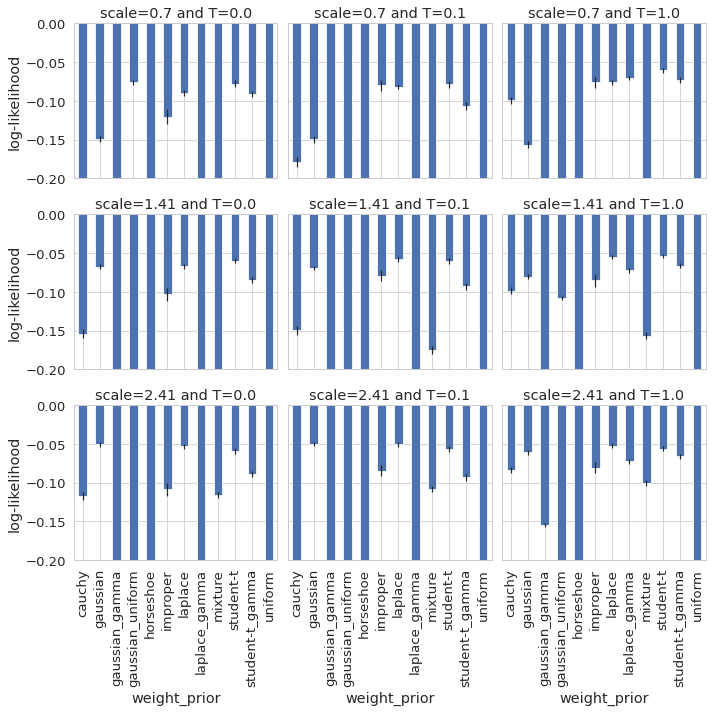

In [14]:
fig = plot_grid(runs_selected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [15]:
fig.savefig(f"../figures/{exp_name}_ll.pdf")

In [16]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

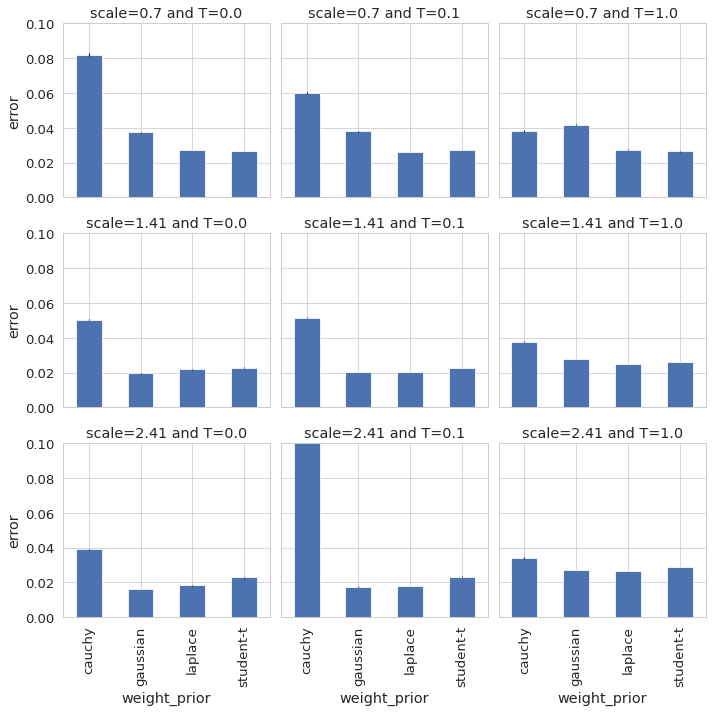

In [17]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.1))

In [18]:
fig.savefig(f"../figures/{exp_name}_acc_monolithic.pdf")

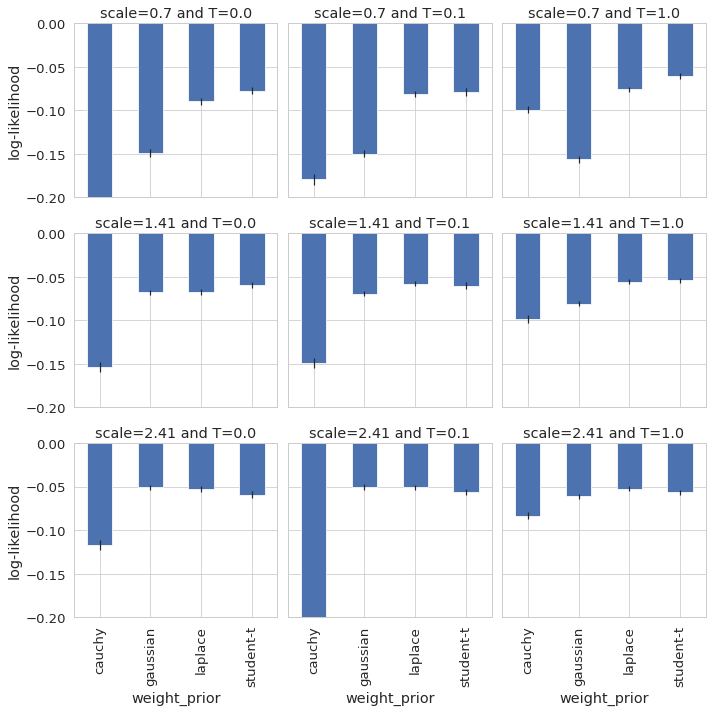

In [19]:
fig = plot_grid(runs_subselected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [20]:
fig.savefig(f"../figures/{exp_name}_ll_monolithic.pdf")

In [21]:
runs_subselected = runs_selected.query(f"weight_prior in {hierarchical_priors}")

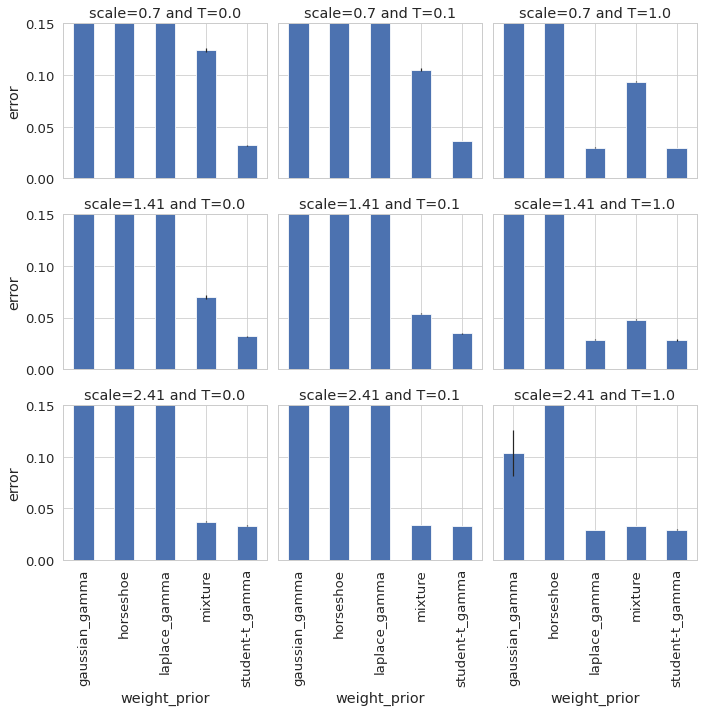

In [22]:
fig = plot_grid(runs_subselected, y="error_mean", yerr="acc_stderr", ylabel="error", ylim=(0, 0.15))

In [23]:
fig.savefig(f"../figures/{exp_name}_acc_hierarchical.pdf")

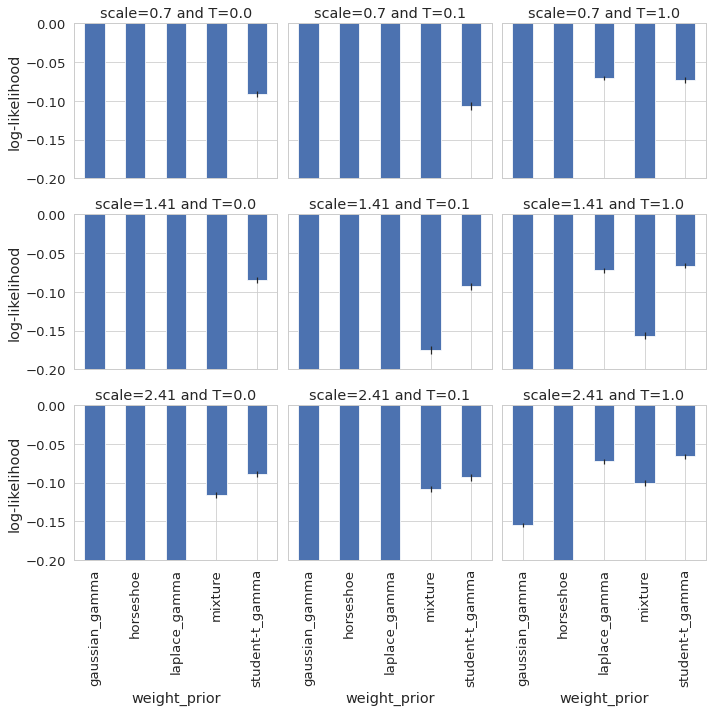

In [24]:
fig = plot_grid(runs_subselected, y="lp_mean", yerr="lp_stderr", ylabel="log-likelihood", ylim=(-0.2, 0))

In [25]:
fig.savefig(f"../figures/{exp_name}_ll_hierarchical.pdf")

## Evaluate mixture models

In [26]:
components = ["gaussian", "laplace", "student-t", "cauchy"]

df_mixture = pd.DataFrame(columns=["weight_scale", "temperature", "layer", "component", "weight", "log_weight"])

for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "mixture":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        mixture_weights = {k[:5]:torch.nn.functional.softmax(v[-1], dim=0).detach().numpy()
                   for k, v in samples.items() if "mixture_weights" in k}
        scale = config['weight_scale']
        temp = config['temperature']
        for layer, weights in mixture_weights.items():
            for comp, weight in zip(components, weights):
                df_mixture.loc[len(df_mixture)] = [scale, temp, layer, comp, weight, np.log(weight)]

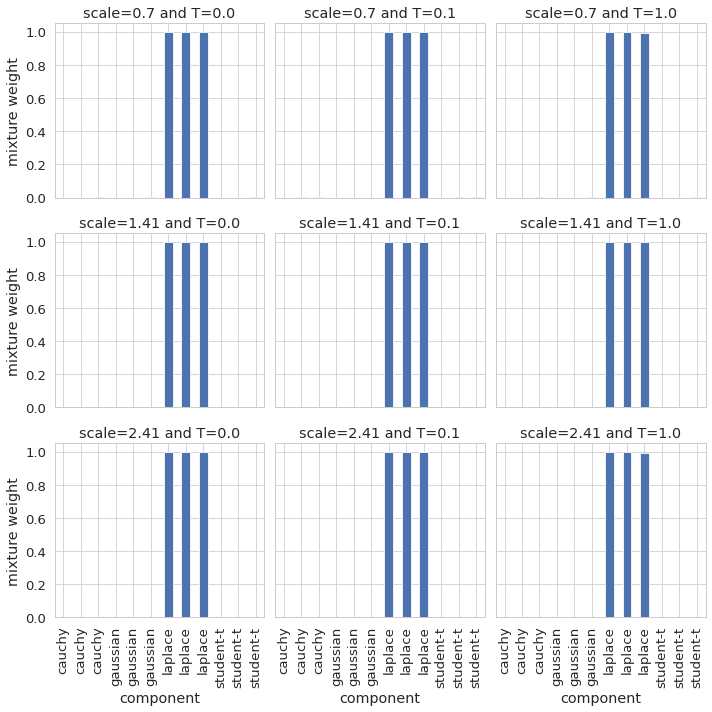

In [27]:
fig = plot_grid(df_mixture, y="weight", ylabel="mixture weight", x="component")

In [28]:
fig.savefig(f"../figures/{exp_name}_mixture_weights.pdf")

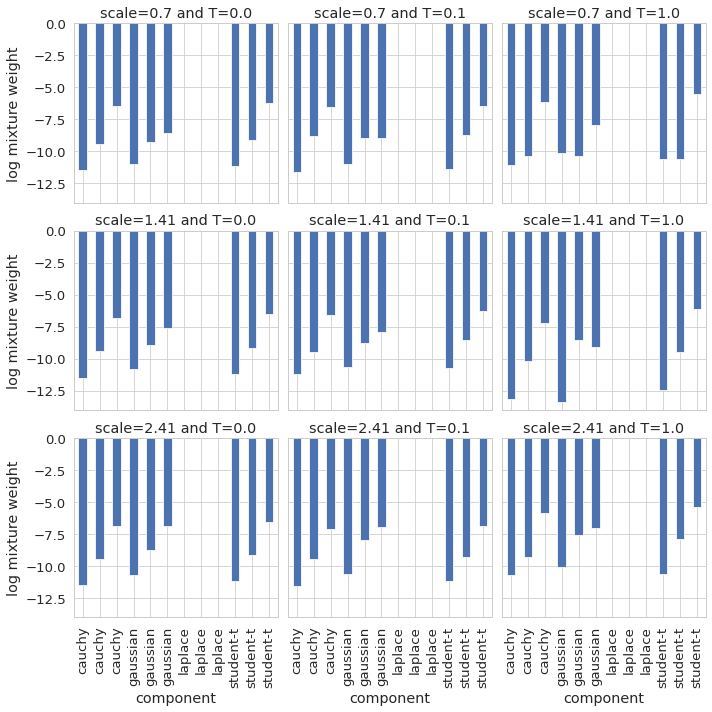

In [29]:
fig = plot_grid(df_mixture, y="log_weight", ylabel="log mixture weight", x="component")

In [30]:
fig.savefig(f"../figures/{exp_name}_mixture_logweights.pdf")

## Evaluate marginal likelihood

In [31]:
runs_selected = runs_selected[runs_selected.weight_prior.apply(lambda val: val not in ["improper", "uniform", "mixture"])]

KeyError: 'simple_logmarglik'

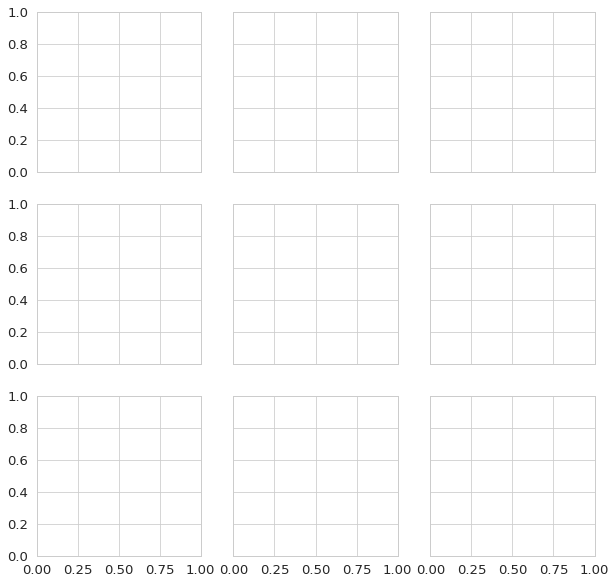

In [32]:
fig = plot_grid(runs_selected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_logmargliks.pdf")

In [ ]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

In [ ]:
fig = plot_grid(runs_subselected, y="simple_logmarglik", ylabel="LML", ylim=(-2e6, 0.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_logmargliks_monolithic.pdf")

In [ ]:
margliks = runs_selected["simple_logmarglik"].values.astype(float)
lls = runs_selected["lp_mean"].values.astype(float)
accs = runs_selected["acc_mean"].values.astype(float)

In [ ]:
print("Correlation between log marginal likelihoods and test log likelihoods:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, lls)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, lls)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, lls)))

print("Correlation between log marginal likelihoods and test errors:")
print("Pearson's r = {0:.3f} with p-value = {1:.2e}".format(*stats.pearsonr(margliks, accs)))
print("Spearman's rho = {0:.3f} with p-value = {1:.2e}".format(*stats.spearmanr(margliks, accs)))
print("Kendall's tau = {0:.3f} with p-value = {1:.2e}".format(*stats.kendalltau(margliks, accs)))

## Evaluate calibration

In [ ]:
assert use_eval_runs, "The calibration and OOD can only be assessed on eval data"

In [ ]:
runs_selected = runs_all.query(f"'{calibration_data}' in eval_data")

In [ ]:
fig = plot_grid(runs_selected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [ ]:
fig.savefig(f"../figures/{exp_name}_rmsce.pdf")

In [ ]:
fig = plot_grid(runs_selected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ece.pdf")

In [ ]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

In [ ]:
fig = plot_grid(runs_subselected, y="rmsce", ylabel="RMSCE", ylim=(0, 0.015))

In [ ]:
fig.savefig(f"../figures/{exp_name}_rmsce_monolithic.pdf")

In [ ]:
fig = plot_grid(runs_subselected, y="ece", ylabel="ECE", ylim=(0, 0.2))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ece_monolithic.pdf")

## Evaluate OOD detection

In [ ]:
runs_selected = runs_all.query(f"'{ood_data}' in eval_data")

In [ ]:
fig = plot_grid(runs_selected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

In [ ]:
fig = plot_grid(runs_selected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood.pdf")

In [ ]:
runs_subselected = runs_selected.query(f"weight_prior in {monolithic_priors}")

In [ ]:
fig = plot_grid(runs_subselected, y="auroc", ylabel="OOD AUROC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

In [ ]:
fig = plot_grid(runs_subselected, y="auprc", ylabel="OOD AUPRC", ylim=(0.5, 1.))

In [ ]:
fig.savefig(f"../figures/{exp_name}_ood_monolithic.pdf")

## Evaluate empirical distribution of weights

In [ ]:
final_weights = None
for config_file in glob(train_files):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    if config["weight_prior"] == "improper":
        samples = torch.load(os.path.join(os.path.dirname(config_file),"samples.pt"))
        final_weights_sample = {param : val[-1] for param, val in samples.items() if "weight_prior" in param}
        if final_weights is None:
            final_weights = final_weights_sample
        else:
            final_weights = {param: torch.cat((final_weights[param], val)) for param, val in final_weights_sample.items()}
final_weights = {param: val.detach().numpy() for param, val in final_weights.items()}

In [ ]:
fig, axs = plt.subplots(nrows=len(final_weights), figsize=(5, 2*len(final_weights)))
for (param, weights), ax in zip(final_weights.items(), axs):
    sns.distplot(weights.flatten(), ax=ax, bins=100)
    ax.set_xlabel(param)
    ax.set_xlim((-2, 2))
fig.tight_layout()

In [ ]:
fig.savefig(f"../figures/{exp_name}_empirical_weightdist.pdf")

In [ ]:
for param, weight in final_weights.items():
    print(f"Normality tests for {param}:")
    print(f"Mean = {weight.flatten().mean():.2f}, std = {weight.flatten().std():.2f}")
    print("D'Angostino: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.normaltest(weight.flatten())))
    print("Shapiro: statistic = {0:.2f}, p-value = {1:.2e}".format(*stats.shapiro(np.random.choice(weight.flatten(), size=5000, replace=False))))